In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

---

In [4]:
train.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [5]:
train['y'].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

In [6]:
train.dtypes

id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [7]:
categoricals = train.select_dtypes(include='object')
categoricals.nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

---
# Baseline Model
## Catboost using Optuna - AUC 0.96729

In [89]:
train_toy_target = train['y']
train_toy = train.drop(columns=['id', 'y'])

x_train, x_test, y_train, y_test = train_test_split(train_toy, train_toy_target, test_size=0.2, random_state=42)

# Assuming x_train is your DataFrame of features
categorical_features_names = x_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Make sure 'remainder__MSZoning' is in this list. It should be if its dtype is object.
print("Detected categorical features:", categorical_features_names)

Detected categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [94]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

def objective(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "verbose": 0,
        "depth": trial.suggest_int("depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 10.0),
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(x_train, y_train):
        X_train_cv, X_valid_cv = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = CatBoostClassifier(**params, cat_features=categorical_features_names)
        model.fit(X_train_cv, y_train_cv)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        aucs.append(auc)

    return np.mean(aucs)


In [95]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-08-04 11:07:54,342] A new study created in memory with name: no-name-a968d9ec-9615-40bd-aaa3-e2b73716db60


[I 2025-08-04 11:09:28,681] Trial 0 finished with value: 0.9240334962923442 and parameters: {'depth': 1, 'learning_rate': 0.006682003314302674, 'l2_leaf_reg': 3.015517926351398, 'iterations': 395, 'subsample': 0.5281147900328264}. Best is trial 0 with value: 0.9240334962923442.
[I 2025-08-04 11:12:06,068] Trial 1 finished with value: 0.9621867885899079 and parameters: {'depth': 2, 'learning_rate': 0.4846340491699786, 'l2_leaf_reg': 6.9245742221984194, 'iterations': 493, 'subsample': 0.5701521884051759}. Best is trial 1 with value: 0.9621867885899079.
[I 2025-08-04 11:19:47,895] Trial 2 finished with value: 0.9650140988589953 and parameters: {'depth': 9, 'learning_rate': 0.2494598522752862, 'l2_leaf_reg': 2.8505602755680344, 'iterations': 407, 'subsample': 0.8519935357719114}. Best is trial 2 with value: 0.9650140988589953.
[I 2025-08-04 11:29:28,320] Trial 3 finished with value: 0.9654991221520429 and parameters: {'depth': 6, 'learning_rate': 0.09868710185852625, 'l2_leaf_reg': 2.29093

Best AUC: 0.9662402409910382
Best Params: {'depth': 7, 'learning_rate': 0.16242304317665213, 'l2_leaf_reg': 9.784139225596583, 'iterations': 991, 'subsample': 0.6576101811374836}


In [101]:
optuna_best_model = CatBoostClassifier(**study.best_params, cat_features=categorical_features_names)

0:	learn: 0.4670392	total: 434ms	remaining: 7m 9s
1:	learn: 0.3480661	total: 875ms	remaining: 7m 12s
2:	learn: 0.2795086	total: 1.31s	remaining: 7m 11s
3:	learn: 0.2433529	total: 1.72s	remaining: 7m 5s
4:	learn: 0.2219173	total: 2.12s	remaining: 6m 58s
5:	learn: 0.2086650	total: 2.52s	remaining: 6m 53s
6:	learn: 0.2003184	total: 2.82s	remaining: 6m 36s
7:	learn: 0.1935392	total: 3.18s	remaining: 6m 31s
8:	learn: 0.1891573	total: 3.52s	remaining: 6m 24s
9:	learn: 0.1856410	total: 3.88s	remaining: 6m 20s
10:	learn: 0.1822869	total: 4.21s	remaining: 6m 15s
11:	learn: 0.1787573	total: 4.55s	remaining: 6m 11s
12:	learn: 0.1769567	total: 4.93s	remaining: 6m 10s
13:	learn: 0.1754878	total: 5.28s	remaining: 6m 8s
14:	learn: 0.1737569	total: 5.65s	remaining: 6m 7s
15:	learn: 0.1727567	total: 6.03s	remaining: 6m 7s
16:	learn: 0.1717238	total: 6.43s	remaining: 6m 8s
17:	learn: 0.1709202	total: 6.93s	remaining: 6m 14s
18:	learn: 0.1698745	total: 7.38s	remaining: 6m 17s
19:	learn: 0.1686768	total: 

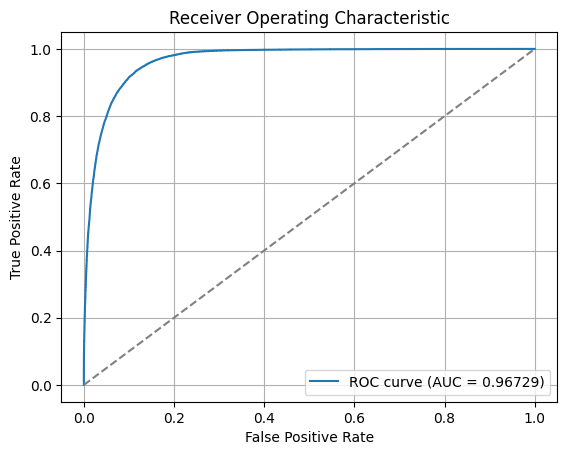

In [102]:
optuna_best_model.fit(x_train, y_train)

optuna_prob = optuna_best_model.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, optuna_prob[:,1])

roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

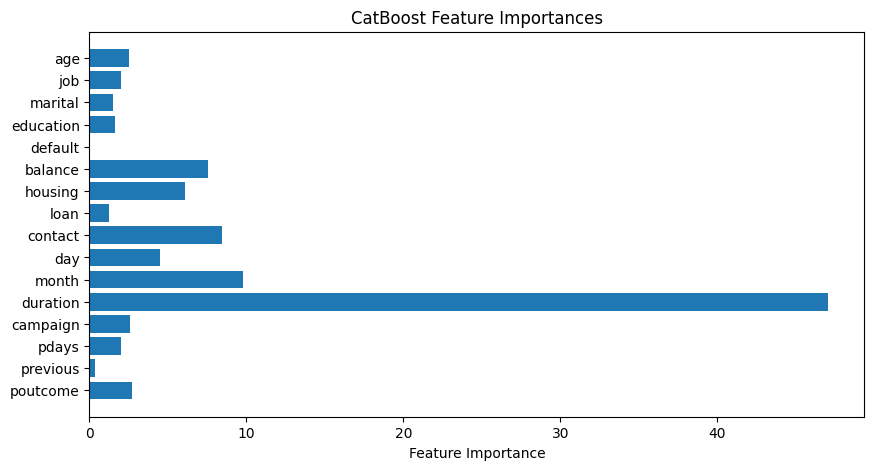

In [106]:
importances = optuna_best_model.get_feature_importance()

feature_names = optuna_best_model.feature_names_

plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importances")
plt.gca().invert_yaxis()
plt.show()


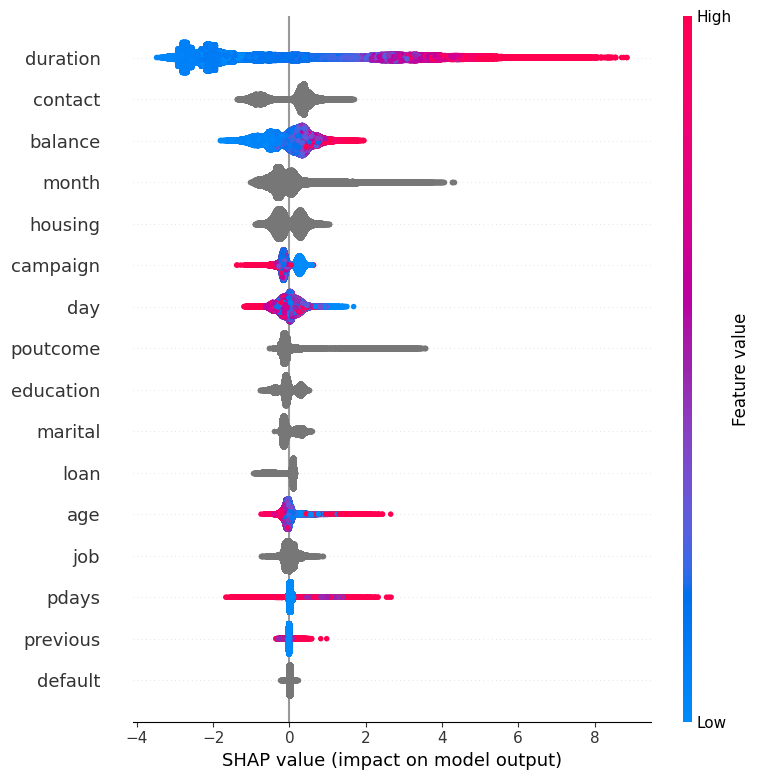

In [108]:
cat_cols = x_test.select_dtypes(include='object').columns.tolist()

from catboost import Pool
import shap

test_pool = Pool(x_test, label=y_test, cat_features=cat_cols, feature_names=x_test.columns.tolist())



shap_values = optuna_best_model.get_feature_importance(
    fstr_type="ShapValues",
    data=test_pool
)


shap.summary_plot(
    shap_values[:, :-1],
    x_test,  # original DataFrame (with categorical features as strings)
    feature_names=optuna_best_model.feature_names_
)


In [103]:
tid = test['id']
tinputs = test.drop(columns=['id'])

tpreds = optuna_best_model.predict_proba(tinputs)

In [104]:
sub1 = pd.DataFrame({'id': test['id'], 'y': tpreds[:,1]})

In [105]:
sub1.to_csv("submissions/cat_optuna_tuned.csv", index=False)

---

In [8]:
numeric_df = train.select_dtypes(include=['int64', 'float64'])

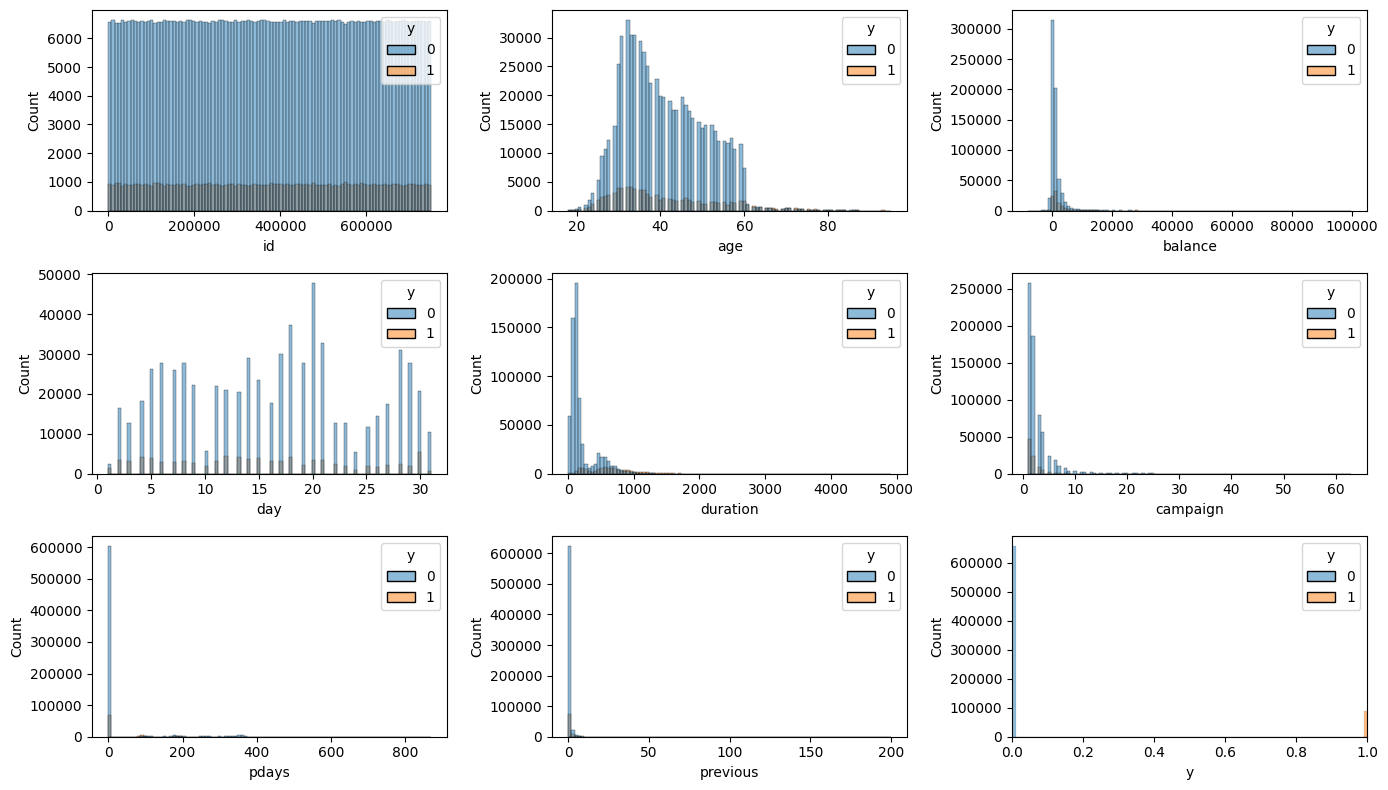

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(14,8))

for i, column in enumerate(numeric_df.columns):

    flat_ax = ax.flatten()

    sns.histplot(data=numeric_df, x=column, ax=flat_ax[i], hue=numeric_df['y'], bins=100)
    plt.xlim(numeric_df[column].quantile(0.02), numeric_df[column].quantile(0.98))

plt.tight_layout()
plt.show()

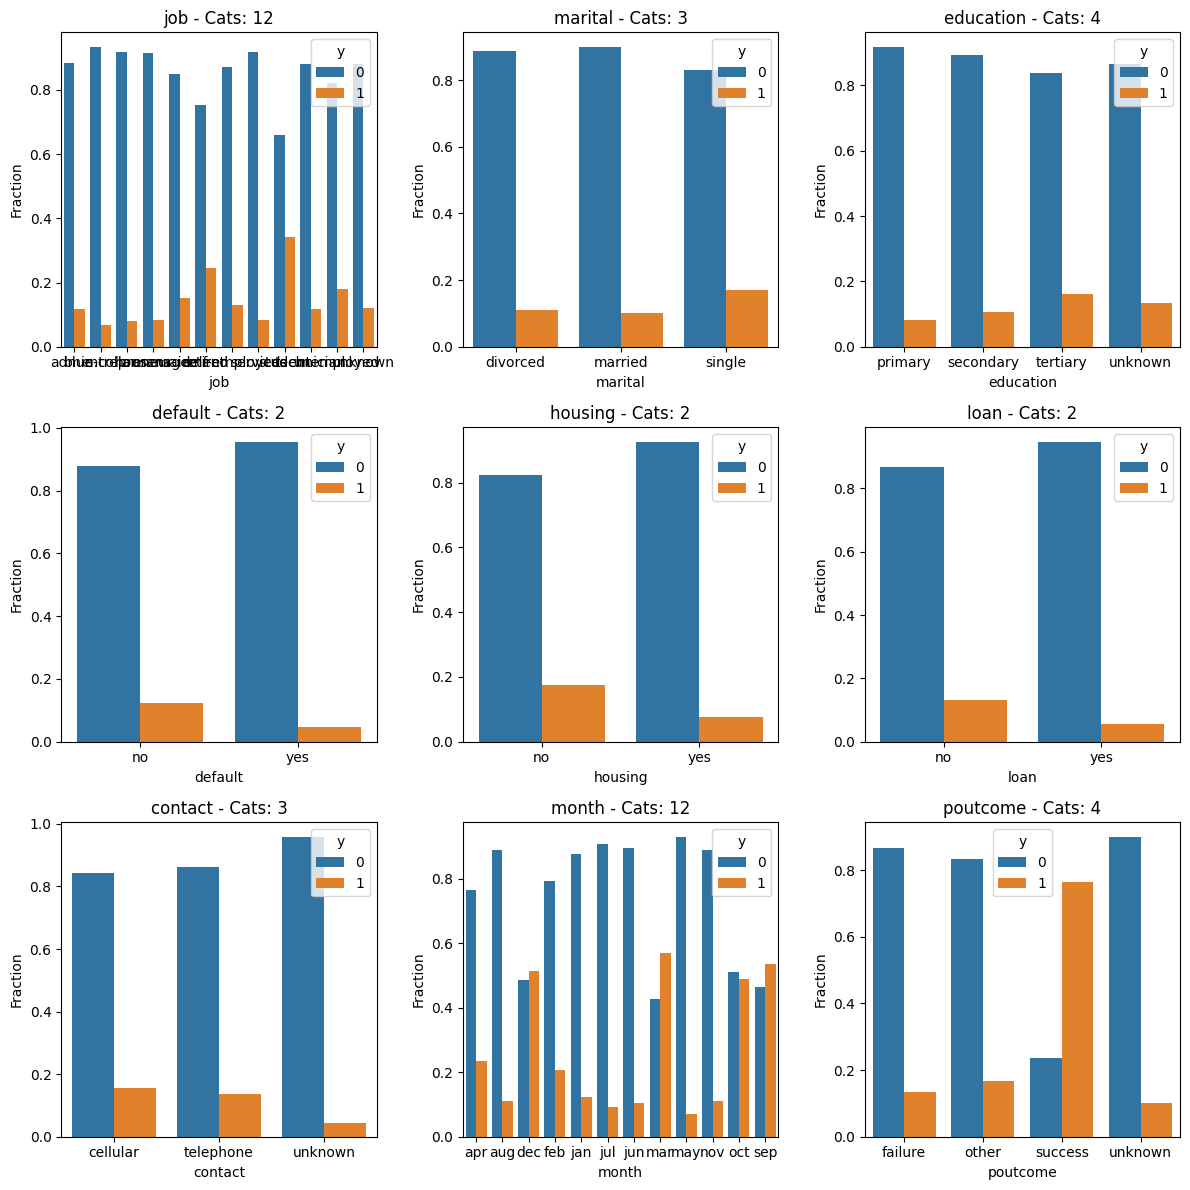

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume train is your DataFrame, categoricals is a DataFrame of your categorical columns, and y is your target column

fig, ax = plt.subplots(3, 3, figsize=(12, 4*3))
flat_ax = ax.flatten()

for i, col in enumerate(categoricals.columns):
    # Calculate proportions
    prop_df = (
        train.groupby(col)['y']
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )
    # Plot
    sns.barplot(
        data=prop_df,
        x=col,
        y='proportion',
        hue='y',
        ax=flat_ax[i]
    )
    flat_ax[i].set_title(f'{col} - Cats: {categoricals[col].nunique()}')
    flat_ax[i].set_ylabel('Fraction')
    flat_ax[i].set_xlabel(col)
    flat_ax[i].legend(title='y')

plt.tight_layout()
plt.show()

---

In [50]:
numeric_cols = numeric_df.columns
categorical_cols = categoricals.columns

In [51]:
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop='if_binary', sparse_output=False), categoricals.columns)
    ],
    remainder="passthrough")

pipeline = Pipeline([
    ("preprocessor", preprocessor),
])
pipeline.set_output(transform='pandas')
        

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))]))])

In [53]:
train

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [54]:
train_transformed = pipeline.fit_transform(train.drop(columns=['id', 'y']))

In [43]:
train_transformed_target = train_transformed['remainder__y']
train_transformed = train_transformed.drop(columns=['remainder__y', 'remainder__id'])

---

In [44]:
from xgboost import XGBClassifier

boost_model = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.0,
    reg_alpha=0.0,
    reg_lambda=1.0,
)

x_train, x_test, y_train, y_test = train_test_split(train_transformed, train_transformed_target, test_size=0.2, random_state=42)

In [45]:
boost_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

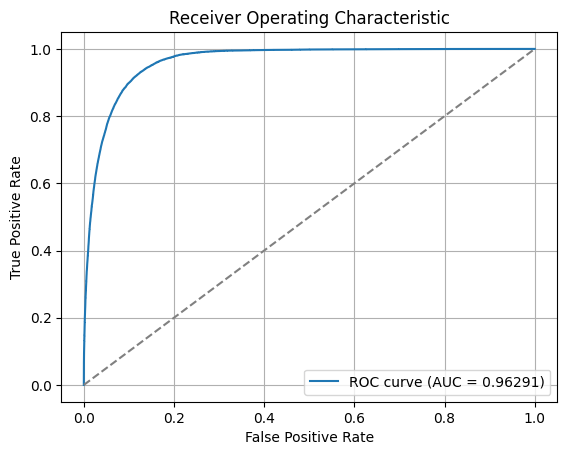

In [47]:
boost_test_proba = boost_model.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, boost_test_proba[:,1])

roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
boost_test_id = test['id']
boost_test = test.drop(columns=['id'])

boost_test_transformed = pipeline.transform(boost_test)

boost_test_proba = boost_model.predict_proba(boost_test_transformed)

boost_test_proba_df = pd.DataFrame({'id': boost_test_id, 'y': boost_test_proba[:,1]})

boost_test_proba_df.to_csv('submissions/boost_test_proba.csv', index=False)

---

# Future Work

- The "day" column is numerical ordinal, but really not, should be encoded or transformed
- Run grid search on the xgboost model